In [1]:
import sys
import os
import random
from collections import Counter
import numpy as np
from scipy.stats import rankdata, kendalltau, spearmanr
# Package
import somhos.resources.dataset as rd
import somhos.resources.queries as rq
from somhos.methods.useful import save_pickle, load_pickle
from somhos.config.paths import *

Default path

In [2]:
data_path = "../../src/somhos/resources/aminer/v9gamma"

Load samples

In [3]:
# Load sample A
docs_sample_a_path = get_relative_path(data_path, DOCS_SAMPLE_A_SUFFIX)
docs_sample_a = load_pickle(docs_sample_a_path)
# Load sample B
docs_sample_b_path = get_relative_path(data_path, DOCS_SAMPLE_B_SUFFIX)
docs_sample_b = load_pickle(docs_sample_b_path)

print("Samples size: (%d, %d)" % (len(docs_sample_a), len(docs_sample_b)))

Samples size: (5000, 5000)


Load samples content

In [4]:
docs_samples_content_path = get_relative_path(data_path, DOCS_SAMPLES_CONTENT)
samples_content = load_pickle(docs_samples_content_path)
print("Docs: %d" % len(samples_content))

Docs: 10000


Load cosine similarity with vectors of TF

In [5]:
m_tf = load_pickle(get_relative_path(data_path, SIM_TF_TOKENS))
print(m_tf)

[[0.02715224 0.01118565 0.02424854 ... 0.03645305 0.00992867 0.0254809 ]
 [0.03927258 0.03698001 0.02312486 ... 0.03544545 0.0164122  0.0382911 ]
 [0.03115607 0.         0.02446083 ... 0.00351499 0.00651014 0.06075487]
 ...
 [0.03653373 0.13760418 0.01434143 ... 0.04533857 0.03816905 0.03116811]
 [0.04034949 0.01329792 0.02217505 ... 0.02549219 0.03541071 0.04819284]
 [0.07293783 0.012019   0.01002119 ... 0.10080221 0.02667093 0.02489026]]


Load cosine similarities with TF vectors from keyphrases 

In [6]:
m_tf_kps = load_pickle(get_relative_path(data_path, SIM_TF_KEYPHRASES))
print(m_tf_kps)

[[0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.0232621 0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 ...
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.        0.        0.       ]
 [0.        0.        0.        ... 0.0232621 0.        0.       ]]


Load cosine similarity with vectors of TF-IDF

In [7]:
m_tf_idf = load_pickle(get_relative_path(data_path, SIM_TF_IDF_TOKENS))
print(m_tf_idf)

[[0.01075387 0.00206247 0.00420691 ... 0.00566958 0.00147329 0.0079679 ]
 [0.00313217 0.01103955 0.01155472 ... 0.01543637 0.00282845 0.00718103]
 [0.00373985 0.         0.00749853 ... 0.00558708 0.00154656 0.02780748]
 ...
 [0.00126982 0.02567927 0.00055769 ... 0.00533172 0.00415633 0.00597354]
 [0.00616515 0.00312923 0.00174796 ... 0.00822055 0.00276756 0.02864622]
 [0.00437217 0.00440589 0.00088447 ... 0.01827149 0.00584807 0.00173718]]


Load cosine similarities with TF-IDF vectors from keyphrases 

In [8]:
m_tf_idf_kps = load_pickle(get_relative_path(data_path, SIM_TF_IDF_KEYPHRASES))
print(m_tf_idf_kps)

[[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.00350385 0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.00314453 0.         0.        ]]


Means to order matrices

In [9]:
m_ref = m_tf
# m_ref = m_tf_kps
# m_ref = m_tf_idf_kps

# Means sample a
means_sample_a = np.divide(np.sum(m_ref, axis=1), len(docs_sample_b))
# Means sample b
means_sample_b = np.divide(np.sum(m_ref, axis=0), len(docs_sample_a))
# Ordered means
ordered_indices_m = means_sample_a.argsort()[::-1]
ordered_indices_n = means_sample_b.argsort()[::-1]

docs_sample_a = list(np.array(docs_sample_a)[ordered_indices_m])
docs_sample_b = list(np.array(docs_sample_b)[ordered_indices_n])

Order matrices by means

In [10]:
m_ref = m_ref[ordered_indices_m,:][:,ordered_indices_n]

# TF
m_tf = m_tf[ordered_indices_m,:][:,ordered_indices_n]
m_tf_kps = m_tf_kps[ordered_indices_m,:][:,ordered_indices_n]

# TF-IDF 
m_tf_idf = m_tf_idf[ordered_indices_m,:][:,ordered_indices_n]
m_tf_idf_kps = m_tf_idf_kps[ordered_indices_m,:][:,ordered_indices_n]

In [11]:
matrices = [
    (m_tf, "TF", "$sim_{wf}(d_i, d_j)$"),
    (m_tf_kps, "TF (Keyphrases)", "$sim_{kf}(d_i, d_j)$"),
    (m_tf_idf, "TF-IDF", "$sim_{wfidf}(d_i, d_j)$"),
    (m_tf_idf_kps, "TF-IDF (Keyphrases)", "$sim_{kfidf}(d_i, d_j)$")
]

In [12]:
m_ref_name = matrices[1][2]

In [13]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.rcParams["figure.figsize"] = (16,16)
mpl.rcParams['figure.dpi']= 300
mpl.rcParams['image.cmap'] = 'viridis'
mpl.rcParams['image.interpolation'] = 'none'
mpl.rcParams['image.lut'] = 2
mpl.rcParams['image.resample'] = False
mpl.rcParams['font.size'] = 22

In [14]:
mmm = np.array([
    [0, 2, 3],
    [5, 7, 9],
    [12, 15, 18]]
)

nnn = np.array([
    [30, 25, 20],
    [8, 12, 16],
    [6, 3, 50]]
)

def mean(X):
    EX = X.mean(1)
    return EX 

def subtract(X):
    EX = mean(X)
    subtract_X = np.subtract(X.transpose(), EX).transpose()
    return subtract_X

def sigma(X):
    subtract_X = subtract(X)
    sum_EX_EX = np.sum(subtract_X**2, 1)
    sigma_X = np.sqrt(np.divide(sum_EX_EX, (X.shape[1] - 1)))
    return sigma_X

def cov(X, Y):
    subtract_X = subtract(X)
    subtract_Y = subtract(Y)
    cov_XY = np.sum((subtract_X)*(subtract_Y), 1)/X.shape[0]
    return cov_XY

def pearson(X, Y):
    cov_XY = cov(X, Y)
    sigma_X = sigma(X)
    sigma_Y = sigma(Y)
    # p = np.array([((cxy/(sigma_X*sigma_Y)[i]) if (sigma_X*sigma_Y)[i] != 0 else float('inf') ) for i, cxy in enumerate(cov_XY)])
    # if cov is zero X Y Are uncorrelated
    p = np.array([((cxy/(sigma_X*sigma_Y)[i]) if cxy else 0.0) for i, cxy in enumerate(cov_XY)])
    return p

print(cov(mmm, nnn), pearson(mmm, nnn))

[-5.          5.33333333 44.        ] [-0.65465367  0.66666667  0.55740877]


In [15]:
# rgX = tf.divide(tf.convert_to_tensor(np.array(list(map(ss.rankdata, sess.run(X))))) , n)
# rgY = tf.divide(tf.convert_to_tensor(np.array(list(map(ss.rankdata, sess.run(Y))))) , n)
def rg(Mat):
    rgMat = np.array(list(map(rankdata, Mat)))
    return rgMat

def spearman(X, Y):
    n_shape = X.shape[1]
    denominator = n_shape * (n_shape**2 - 1)
    r_s = 1 - np.divide(6*np.sum((rg(X) - rg(Y))**2, 1), denominator)
    return r_s

def spearman2(X, Y):
    print(X, Y)
    print(list(map(lambda x, y: np.stack((x, y), axis=1), X, Y)))
    r_s = np.array([rho for rho, _ in map(lambda x, y: spearmanr(np.stack((x, y), axis=1)), X, Y)])
    return r_s

def kendall(X, Y):
    tau = np.array([tau for tau, _ in map(kendalltau, X, Y)])
    return tau

rgX_ = rg(mmm)
print(rgX_)
print("----")
rgY_ = rg(nnn)
print(rgY_)
print("####")
print(spearman(mmm, nnn))
print(spearman2(mmm, nnn))
print("****")
print(kendall(mmm, nnn))

[[1. 2. 3.]
 [1. 2. 3.]
 [1. 2. 3.]]
----
[[3. 2. 1.]
 [1. 2. 3.]
 [2. 1. 3.]]
####
[-1.   1.   0.5]
[[ 0  2  3]
 [ 5  7  9]
 [12 15 18]] [[30 25 20]
 [ 8 12 16]
 [ 6  3 50]]
[array([[ 0, 30],
       [ 2, 25],
       [ 3, 20]]), array([[ 5,  8],
       [ 7, 12],
       [ 9, 16]]), array([[12,  6],
       [15,  3],
       [18, 50]])]
[-1.   1.   0.5]
****
[-1.          1.          0.33333333]


TF
$X_i = sim_{kf}(d_i, d_j \in D_b), Y_i = sim_{wf}(d_i, d_j \in D_b)$
TF (Keyphrases)
$X_i = sim_{kf}(d_i, d_j \in D_b), Y_i = sim_{kf}(d_i, d_j \in D_b)$
TF-IDF
$X_i = sim_{kf}(d_i, d_j \in D_b), Y_i = sim_{wfidf}(d_i, d_j \in D_b)$
TF-IDF (Keyphrases)
$X_i = sim_{kf}(d_i, d_j \in D_b), Y_i = sim_{kfidf}(d_i, d_j \in D_b)$


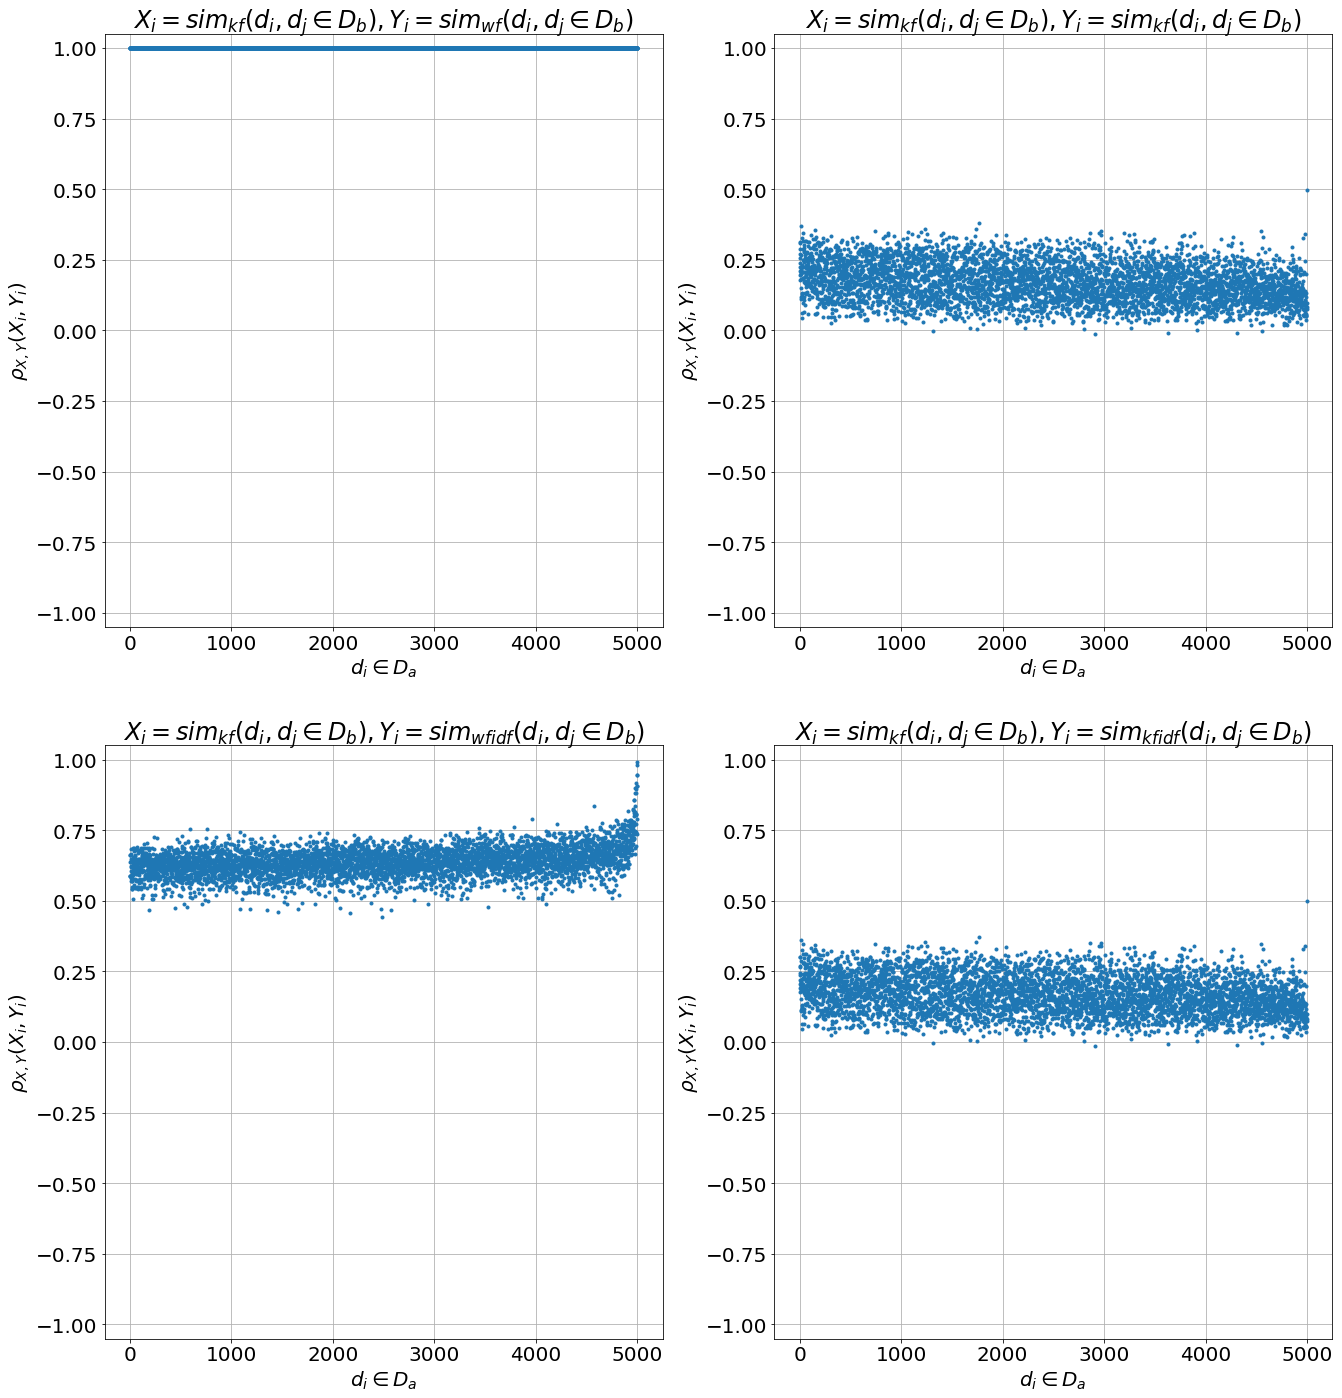

In [16]:
nrows = int(np.ceil(len(matrices)/2))
ncols = 2

mpl.rcParams.update({'font.size': 20})
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(22, 24))
# fig.suptitle("Stats")

X = m_ref 
matrices_iter = iter(matrices)
for i in range(0, nrows):
    for j in range(0, ncols):
        matrix, title, title2 = next(matrices_iter)
        Y = matrix
        # data
        # axes[i][j].plot(cov(X, Y), '.')
        # axes[i][j].plot(spearman(X, Y), '.')
        axes[i][j].plot(kendall(X, Y), '.')
        # axes[i][j].plot(spearman2(X, Y), '.')
        # axes[i][j].plot(pearson(X, Y), '.')
        axes[i][j].set_ylim([-1.05, 1.05])
        print(title)
        title_fmt = r'X_i = ' + m_ref_name + r', Y_i = ' + title2
        title_fmt = r'$' + title_fmt.replace("d_j", "d_j \in D_b").replace("$", "") + r'$' 
        print(title_fmt)
        axes[i][j].set_title(title_fmt)
        axes[i][j].set_xlabel(r'$d_i \in D_a$')
        axes[i][j].set_ylabel(r'$\rho_{X, Y}(X_i, Y_i)$')
        # axes[i][j].set_ylabel(r'$\rho_{X, Y}(' + m_ref_name + ', ' + title2.replace(r"$", "") +')$')
        axes[i][j].grid(True)
plt.show()

Above, means there is less correlation between word and keyphrases measures when using methods with emphasis in content than with methods based on word2vec, mostly it could be a problem of a very general centroid. It is not easy to interpret. 